In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class vonMises:
    def __init__(self):
        self.sig0 = cp.Parameter()
    def criterion(self, sig):
        dev = np.array([[2/3., -1/3., -1/3., 0],
                        [-1/3., 2/3., -1/3., 0],
                        [-1/3., -1/3., 2/3., 0],
                        [0, 0, 0, 1]])
        s = dev@sig
        return [np.sqrt(3/2)*cp.norm(s) <= self.sig0]

class Rankine:
    def __init__(self):
        self.fc = cp.Parameter()
        self.ft = cp.Parameter()
    def criterion(self, sig):
        Sig = cp.bmat([[sig[0], sig[3]/np.sqrt(2), 0],
                      [sig[3]/np.sqrt(2), sig[1], 0],
                      [0, 0, sig[2]]])
        return [cp.lambda_max(Sig) <= self.ft, cp.lambda_min(Sig) >= -self.fc]
    
class IsotropicElasticity:
    def __init__(self, E, nu):
        self.E = E
        self.nu = nu
        self.lmbda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)
    
    def C(self):
        l, m = self.lmbda, self.mu
        return np.array([[l+2*m, l, l, 0],
                        [l, l+2*m, l, 0],
                        [l, l, l+2*m, 0],
                        [0, 0, 0, 2*m]])

class Material:
    def __init__(self, elasticity, yield_criterion, plane_stress=False):
        self.C = elasticity.C()
        self.criterion = yield_criterion.criterion
        self.plane_stress = plane_stress
    
vM = vonMises()
vM.sig0.value = 1.

Ra = Rankine()
Ra.fc.value = 2.
Ra.ft.value = 1.

mat = Material(IsotropicElasticity(1, 0.3), Ra, plane_stress=True)
                        
class ReturnMapping:
    def __init__(self, mat, solver=cp.SCS):
        self.mat = mat
        self.deps = cp.Parameter((4,))
        self.sig_old = cp.Parameter((4,))
        self.sig_elas = self.sig_old + self.mat.C @ self.deps
    
        self.sig = cp.Variable((4, ))
        obj = cp.quad_form(self.sig - self.sig_elas, np.linalg.inv(self.mat.C))
        
        self.cons = mat.criterion(self.sig)
        if self.mat.plane_stress:
            self.cons.append(self.sig[2] == 0)
        self.prob = cp.Problem(cp.Minimize(obj), self.cons)
        self.solver = solver
        
    def solve(self, **kwargs):
        self.prob.solve(solver=self.solver, requires_grad=True, **kwargs)
        self.sig_old.value = self.sig.value
        self.C_tang = np.zeros((4, 4))
        for i in range(4):
            z = np.zeros((4,))
            z[i] = 1
            self.deps.delta = z
            self.prob.derivative()
            self.C_tang[i, :] = self.sig.delta
    
rm = ReturnMapping(mat)
rm.sig_old.value = np.zeros(((4,)))


N = 100
theta = np.linspace(0, 2*np.pi, N+1)
Eps = 10*np.vstack((np.cos(theta), np.sin(theta), 0*theta, 0*theta)).T
Sig = []

for i, t in enumerate(theta):
    rm.sig_old.value = np.zeros((4, ))
    rm.deps.value = Eps[i,:]
    rm.solve()
    Sig.append(rm.sig.value)
    #Eps.append(Eps[-1]+rm.deps.value)

Sig = np.asarray(Sig)
Eps = np.asarray(Eps)

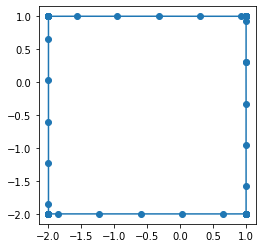

In [3]:
plt.plot(Sig[:, 0], Sig[:, 1], "-o")
plt.gca().set_aspect("equal")